# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

from frozendict import frozendict

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'

In [3]:
def read_cancer_dataset(path_to_csv):
    '''
    Возвращает пару из X и y. 
    X - массив векторов. 
    y - соответствующие векторам метки
    '''
    data = pd.read_csv(path_to_csv)
    X = data.drop('label', axis=1)
    y = (data['label'] == 'M').astype(np.int32)
    
    return X, y

def read_spam_dataset(path_to_csv):
    '''
    Возвращает пару из X и y. 
    X - массив векторов. 
    y - соответствующие векторам метки
    '''
    data = pd.read_csv(path_to_csv)
    X = data.drop('label', axis=1)
    y = data['label']
    
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [7]:
def train_test_split(X, y, ratio=0.9):
    '''
    Возвращает X_train, y_train, X_test, y_test
    X_train и X_test - массив векторов - две части массива X, 
    разделенного в состветсви с коэффициентом ratio.
    y_train и y_test - соответствующие X_train и X_test метки классов
    '''
    
    test_size = int(X.shape[0] * (1-ratio))
    test_indexes = np.random.choice(X.index,
                                    size=test_size,
                                    replace=False)
    X_train = X.drop(test_indexes)
    y_train = y.drop(test_indexes)
    
    X_test = X.loc[test_indexes]
    y_test = y.loc[test_indexes]
    
    return X_train, y_train, X_test, y_test

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [93]:
def get_precision_recall_accuracy(y_pred, y_true):
    '''
    Возвращает precision, recall и accuracy
    precision - набор значений метрики precision для каждого класса
    recall - набор значений метрики recall для каждого класса
    accuracy - число, отражающее общую точность предсказания
    '''
    
    classes = pd.concat([y_pred, y_true]).unique()
    
    precision = {}
    recall = {}
    for cls in classes:
        true_cls = y_true == cls
        pred_cls = y_pred == cls
        
        TP = (true_cls & pred_cls).sum()
        FP = (-true_cls & pred_cls).sum()
        FN = (true_cls & -pred_cls).sum()
        
        precision[cls] = TP / (TP + FP)
        recall[cls] = TP / (TP + FN)
        
    accuracy = (y_pred == y_true).sum() / y_true.size
    
    return list(precision.values()), list(recall.values()), accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [9]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [113]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [row[0] for index, row in knearest.predict_proba(X_test).iterrows()]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [91]:
class KNearest:
    
    def __init__(self, n_neighbors=5, leaf_size=30):
        assert n_neighbors > 0
        assert leaf_size > 0
        
        self.k = n_neighbors
        self.leaf_size = leaf_size
        
    
    def fit(self, X, y):
        sys.setrecursionlimit(y.size * 2)
        
        self.X = X
        self.y = y
        self.classes = y.unique()
        
        unique_count = lambda x: np.unique(x).size
        self.features = X.apply(unique_count).sort_values(ascending=False).index
        
        def make_branch(node, indices, par=None, level=0):
            node['parent'] = par
            node['elements'] = indices
            node['size'] = X.loc[indices].shape[0]
            
            if node['size'] > self.leaf_size:
                
                # selection of the optimal feature for separation
                count_iter = 0
                while True:  
                    if count_iter >= len(self.features):
                        return
                    
                    try:
                        feature = self.features[level]
                    except IndexError:
                        level = 0
                        feature = self.features[level]

                    edge = X.loc[indices][feature].median()
                    dichotomy = X.loc[indices][feature] <= edge
                    
                    if abs(dichotomy.sum() / node['size'] - 0.5) > 0.2:
                        level += 1
                        count_iter += 1
                        continue
                    break
            
                node['feature'] = feature
                node['edge'] = edge
                node[0] = {}
                node[1] = {}

                make_branch(node[0], indices[dichotomy], (node, 0), level+1)
                make_branch(node[1], indices[-dichotomy], (node, 1), level+1)
                
               
            # freezing for srcurity reasons
            if par:
                par[0][par[1]] = frozendict(node)
            else:
                self.kdtree = frozendict(self.kdtree)
            
            
        self.kdtree = {}
        make_branch(self.kdtree, X.index)     
            
        
    def predict_proba(self, X):
        '''
        Возвращает матрицу, в которой строки соответствуют элементам X,
        а столбцы - классам. На пересечении строки и столбца должна быть
        указана вероятность того, что элемент относится к классу.
        
        Вероятность рассчитывается как количество ближайших соседей с
        данным классом деленное на общее количество соседей.
        '''
        
        def find_neighbors(x):
            volume = self.kdtree
            
            while 'feature' in volume.keys():
                feature = volume['feature']
                edge = volume['edge']
                
                if x[feature] <= edge and volume[0]['size'] >= self.k:
                    volume = volume[0]
                elif x[feature] > edge and volume[1]['size'] >= self.k:
                    volume = volume[1]
                else:
                    break
                
            return volume['elements']
        
        
        def order_neighbors(x, neighbors_indx):
            
            def euclidian_norm_2(x_i):
                return ((x_i - x)**2).sum()
            
            dists = self.X.loc[neighbors_indx].apply(euclidian_norm_2, axis=1)
            return dists.sort_values().index
        

        neighbors = X.apply(find_neighbors, axis=1)
        y_pred_prob = pd.DataFrame(columns=self.classes)
        for i in X.index:
            knn = order_neighbors(X.loc[i], neighbors.loc[i])[:self.k]
            
            probs = pd.Series(data=[0, 0], index=self.classes, dtype=np.float64)
            for nb in knn:
                probs[self.y[nb]] += 1
                
            probs /= self.k
            y_pred_prob.loc[i] = probs

        return y_pred_prob
            

    def predict(self, X):
        return self.predict_proba(X).apply(lambda x: self.classes[np.argmax(x)], axis=1)


Наконец, протестируем наш классификатор на различных наборах данных

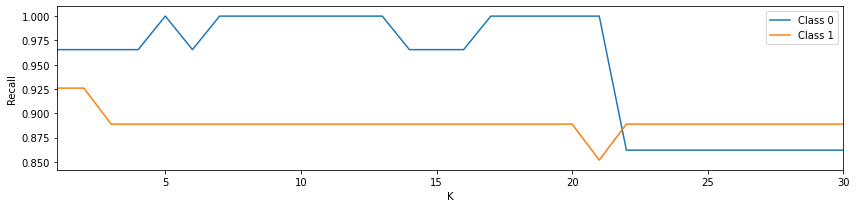

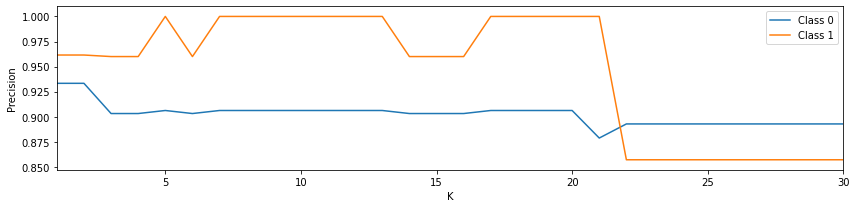

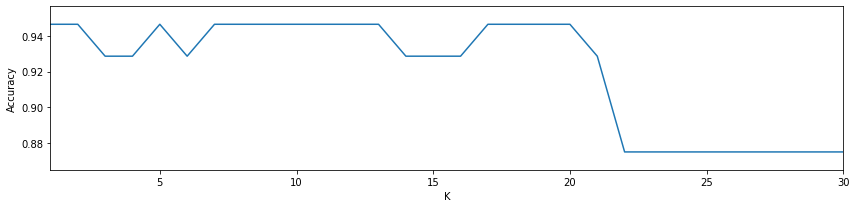

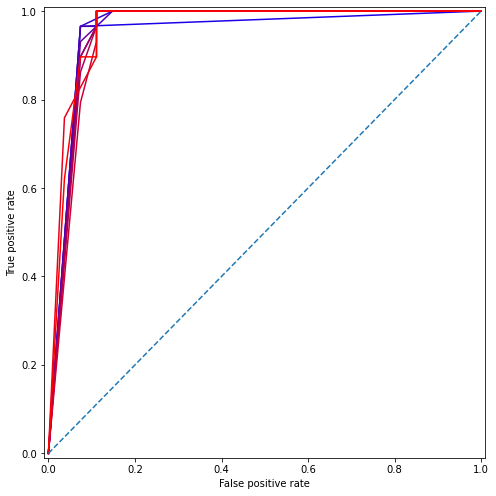

In [115]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

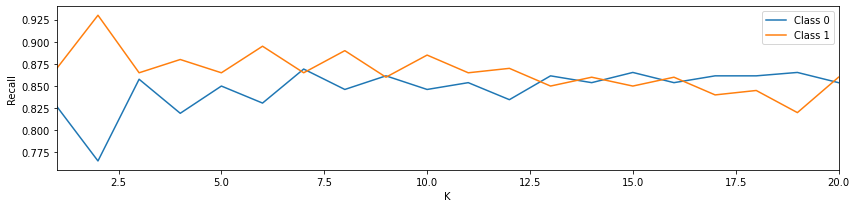

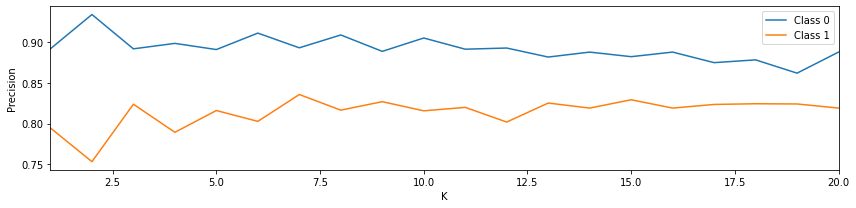

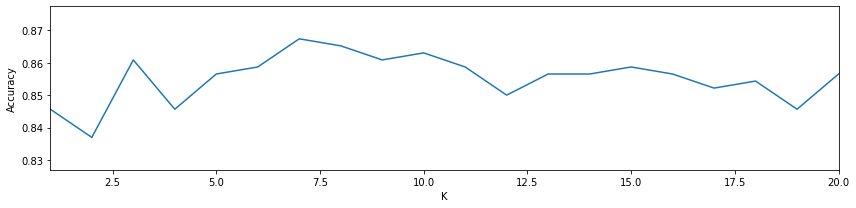

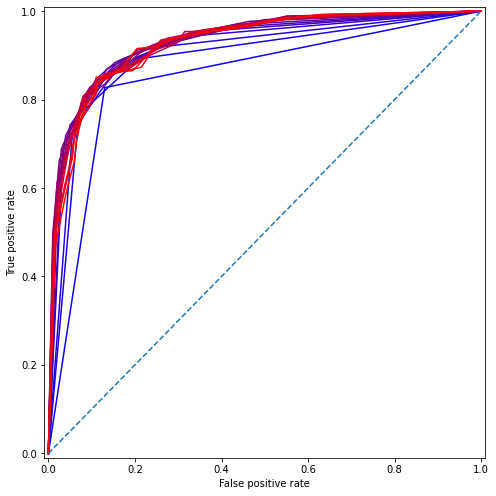

In [116]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

Оптимальным кажется относительно небольшой k (5 для первого датасета и 7 для второго, но это не точно). 

В силу сбалансированности датасетов accuracy показывает себя как довольно неплохое усреднение, однако из контекста в каждом из случаев определяется наиболее важная метрика:
* recall для злокачественности опухоли
* precision для спамности сообщения

Наиболее информативной для определения качества модели же мне кажется AUC, которая тут не вычислена, но мы помним про нее и видим что она очень высокая!

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [2]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [3]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

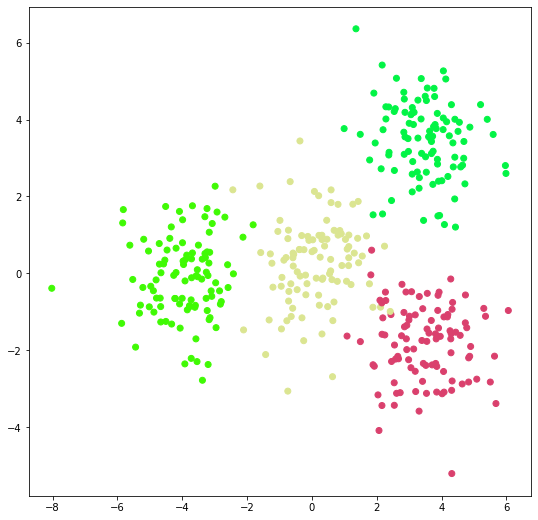

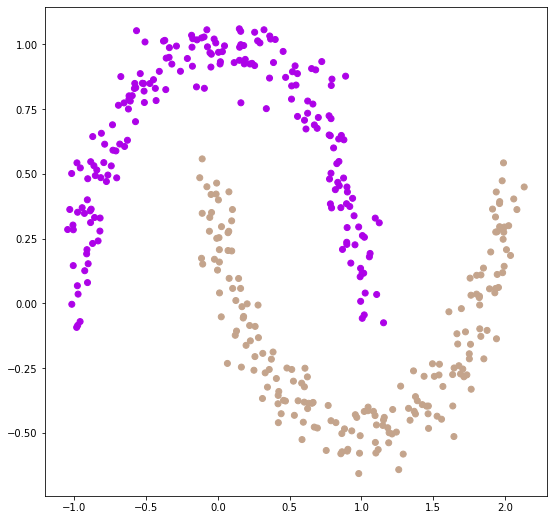

In [4]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [131]:
class KMeans:
    def __init__(self, n_clusters=4, init="random", max_iter=300):
        self.k = n_clusters
        self.init_type = init
        self.max_iter = max_iter
        self.eps = 0
        
    def fit(self, X, y=None):
        
        # initialization of centers
        if self.init_type == 'random':
            features_min = X.min(axis=0)
            features_range = X.max(axis=0) - features_min
            centers = features_min + features_range * np.random.rand(self.k, X.shape[1])
        elif self.init_type == 'sample':
            cenrers_ind = np.random.choice(
                np.arange(X.shape[0]),
                size=self.k,
                replace=False)
            centers = X[cenrers_ind]
        elif self.init_type == 'k-means++':
            centers = np.empty((self.k, X.shape[1]))
            centers[0] = X[np.random.choice(np.arange(X.shape[0]))]
            centers_dist = np.empty((X.shape[0], self.k))
            for i in range(1, self.k):
                centers_dist[:, i-1] = ((X - centers[i-1])**2).sum(axis=1)
                
                probs = centers_dist[:, :i].min(axis=1)
                probs /= probs.sum()
                centers[i] = X[np.random.choice(
                    np.arange(X.shape[0]),
                    p=probs
                )]
        else:
            raise KeyError(self.init_type)
        
        # initial labeling
        centers_dist = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            centers_dist[:, i] = ((X - centers[i])**2).sum(axis=1)
        
        labels = centers_dist.argmin(axis=1)
        
        # if centers are bad
        if np.unique(labels).size < self.k:
            return self.fit(X)
        
        # moving of centers
        new_centers = np.zeros_like(centers)
        centers_shift_max = self.eps + 1
        while centers_shift_max > self.eps:
        
            for i in range(self.k):
                new_centers[i] = X[labels == i].mean(axis=0)
                centers_dist[:, i] = ((X - new_centers[i])**2).sum(axis=1)
                
            labels = centers_dist.argmin(axis=1)   
            
            centers_shift_max = ((new_centers - centers)**2).sum(axis=1).max()
            centers = new_centers
        
        self.centroids = centers
        
    
    def predict(self, X):
        
        centers_dist = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            centers_dist[:, i] = ((X - self.centroids[i])**2).sum(axis=1)
        
        return centers_dist.argmin(axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

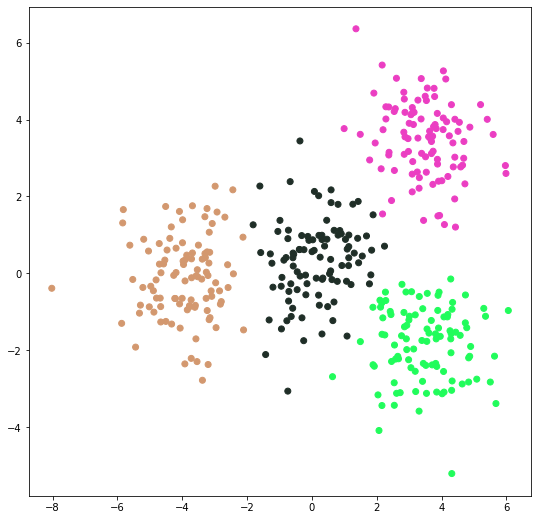

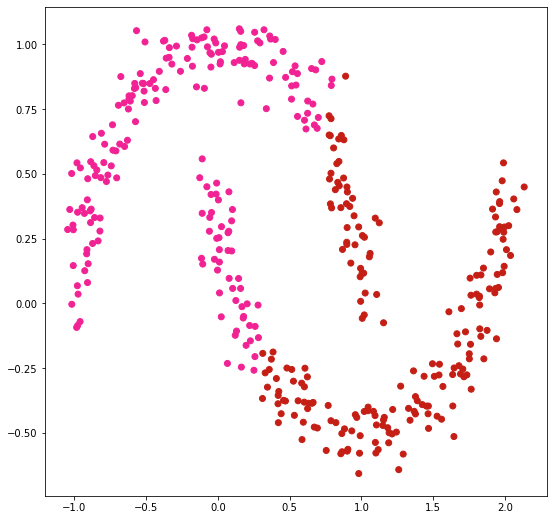

In [153]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [190]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        
        n, m = X.shape
        distance_matrix = np.zeros((n,n))
        for i in range(m):
            col = X[:, i:i+1]
            distance_matrix += (col - col.T)**2
        distance_matrix **= 0.5
        
        neighbors = distance_matrix < self.eps
        n_neighbors = neighbors.sum(axis=1)
        centers = n_neighbors >= self.min_samples
        
        return centers.astype(int)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

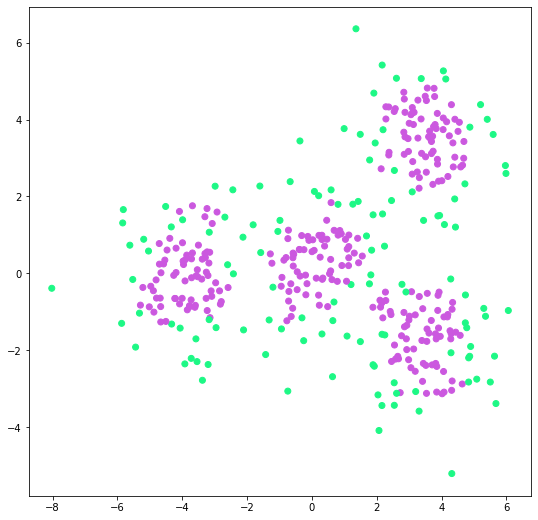

IndexError: index 1 is out of bounds for axis 0 with size 1

In [192]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan()
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

_Ваш ответ_

In [ ]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [17]:
# YOUR_CODE

### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [18]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [21]:
# YOUR_CODE